In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = pd.read_csv('../Datasets/INTC Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [24]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

[[0.26853339 0.2641726  0.2627955  ... 0.25154923 0.25751664 0.26072986]
 [0.2641726  0.2627955  0.26577921 ... 0.25751664 0.26072986 0.26072986]
 [0.2627955  0.26577921 0.26876291 ... 0.26072986 0.26072986 0.25889373]
 ...
 [0.65848061 0.71517099 0.70254762 ... 0.74179481 0.74087675 0.70621988]
 [0.71517099 0.70254762 0.72963048 ... 0.74087675 0.70621988 0.71081019]
 [0.70254762 0.72963048 0.75969704 ... 0.70621988 0.71081019 0.71081019]]


In [28]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [50]:
# 8. Define LSTM Model

model=Sequential()
# model.add(LSTM(50,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 94ms/step - loss: 0.0743 - val_loss: 0.0057
Epoch 2/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0082 - val_loss: 0.0112
Epoch 3/100
17/17 [==============================] - 1s 66ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 4/100
17/17 [==============================] - 1s 63ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 5/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 7/100
17/17 [==============================] - 2s 99ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/100
17/17 [==============================] - 2s 101ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 9/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0029 - val_loss: 0.002

In [52]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 20ms/step


In [53]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [54]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [55]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.09919569]
101
1 day input [0.06105118 0.08790452 0.10121643 0.10420014 0.11361028 0.12370897
 0.11957769 0.10787239 0.08974065 0.08078953 0.09915079 0.12324994
 0.11521689 0.11016755 0.11911866 0.07482213 0.0700023  0.07711728
 0.09570806 0.12141382 0.12439752 0.08698646 0.09524902 0.07665825
 0.06495295 0.06655956 0.08377324 0.08583888 0.09065871 0.07574019
 0.06219876 0.02662382 0.0130824  0.01629562 0.00550838 0.
 0.00068855 0.00986918 0.02983704 0.03442736 0.02501721 0.01445949
 0.0247877  0.03534542 0.05324765 0.04705072 0.07137939 0.08056002
 0.1211843  0.11269222 0.0977737  0.0817076  0.07413358 0.09478999
 0.10236401 0.09823273 0.1007574  0.15193941 0.1650218  0.17833372
 0.18338306 0.18820289 0.18200597 0.18154694 0.17489098 0.17098921
 0.16341519 0.16593987 0.16043149 0.16616938 0.1590544  0.14344733
 0.13679137 0.12393849 0.10924948 0.09134726 0.09524902 0.1138398
 0.14138168 0.12393849 0.11177416 0.13197154 0.14551297 0.13977507
 0.13472573 0.11934818 0.11636447 0.090888

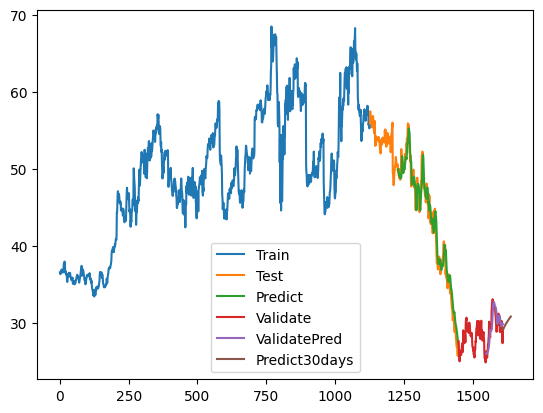

In [56]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+time_step+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

Testing RMSE: 43.59317353344682
Testing MAE: 43.03796565348478
Validation RMSE: 29.716700878779843
Validation MAE: 29.652351567390127


In [58]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[29.22195617 29.19653179 29.23871672 29.30948784 29.39032743 29.4726486
 29.55269676 29.62906242 29.70146703 29.77016155]


In [59]:
print(df['Price'].tail(10))

1601    29.80
1602    29.22
1603    28.87
1604    29.68
1605    29.93
1606    30.28
1607    29.51
1608    29.00
1609    27.40
1610    29.00
Name: Price, dtype: float64


In [60]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'INTC LSTM data (7:2:1)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()